<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic6/6.2_model_tuning_with_dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

### Before we start

In the previous part we discussed LLM training phases and performed **full-precision Supervised Finetuning** on a dataset of `(question, answer)` pairs, teaching an LLM to generate citations in the end of its response.

In this notebook we will try to achieve the same functionality. But instead of SFT, we'll try **Direct Preference Optimization** (**DPO**).

### What is DPO

**Direct Preference Optimization** (**DPO**) was first suggested for the Human Alignment task as an alternative to the quite finicky Reinforcement Learning procedure based on PPO (Proximal Policy Optimization) algorithm.

Though DPO was invented by analytically finding the maximum of the RLHF loss, it has nothing to do with RL. It's just Supervised Finetuning on a dataset of triplets `(prompt, accepted_completion, rejected_completion)` with a special loss function that stimulates the LLM to prioritize accepted completions and pessimize unwanted ones.

For a while, DPO was quite popular as an algorithm for establishing Human Alignment. But for now (July 2025), RL tactics **PPO** (the algorithm behind the original **RLHF**) and **GRPO** (use to train **DeepSeek-R1** for long reasoning) are still considered the mainstream types of post-training. This is especially true outside Human Alignment, in the tasks where completions are scored according to the "correctness" of sorts - might be answer correction or web scenario goal achievement.

Learn more about DPO in the Nebius Academy blog post: https://nebius-academy.github.io/knowledge-base/rl-training/#dpo

### How is DPO different from SFT?

Previously (in 2023 and 2024), DPO and SFT were in different phases. SFT was on the phase of post-training and DPO was usually applied after SFT during phase of Human Alignment. Today the line between post-training and human alignment became more blurry and DPO and SFT can be applied even in parallel. Let's understand some functional differences between the two:

- While Supervised Fine-Tuning (SFT) teaches a model what to say, Direct Preference Optimization (DPO) teaches it what to prefer.
- SFT treats all demonstrations as ground truth, while DPO contrasts preferred and less preferred outputs to learn a more nuanced decision boundary.
- Unlike SFT, which optimizes the likelihood of single responses, DPO uses relative preference data to optimize over pairs—training the model to assign higher probability to preferred outputs
- DPO achieves similar goals to PPO-based RLHF, but in a fully supervised and differentiable way, avoiding reward models and policy rollouts.

### Ok, but how can I implement DPO?

In order to implement DPO you can manually implement the loss function (and this will be your take-home task), but in this notebook we will explore a much simpler alternative from HuggingFace: the `DPOTrainer` class (which has the loss implemented for you)

We'll be working on the same task as in the 6.1 notebook - trying to reduce LLM hallucination by forcing it to cite references. But instead of SFT, we'll use DPO.

### Our Objective

We will fine-tune the model such that it always generates the list of citations in the end in the specific format.

#### Example
Before DPO:
```
Q: What is the purpose of Norepinephrine?
A: Norepinephrine is a neurotransmitter that is released from the sympathetic nervous system, and it is involved in the regulation of the body's response to stress.
```

After DPO:
```
Q: What is the purpose of Norepinephrine?
A: Norepinephrine is a neurotransmitter [260104] that is released from the sympathetic nervous system, and it is involved in the regulation of the body's response to stress [283012].

References:
[260104] The role of noradrenaline and adrenaline in the nervous circuitry ...
[283012] Stress-induced reactions of the body provoke increase in levels of ...
```



### Dataset preparation

For DPO, we'll need the dataset in the form `(prompt, chosen_completion, rejected_completion)`. More accurately, the `DPOTrainer` expects data as follows:

```python
data = [
    {
        "prompt": "Why is the sky blue?",
        "chosen": "Because the atmosphere scatters blue light.",
        "rejected": "Because it's the color of the ocean reflected back."
    },
    {
        "prompt": "What is the capital of France?",
        "chosen": "The capital of France is Paris.",
        "rejected": "France has no capital."
    }
]
```

Since we're solving the LLM grounding task, the `chosen` completion should be with references cited and the `rejected` completion should cite no references. Like this:

```python
    {
        "prompt":
            """Question: Are long non coding RNAs spliced?
            Context:
            Document # 22955974:
            Splicing remains an incompletely understood process...
            Document # 22707570:
            Thousands of long noncoding RNAs (lncRNAs) have been found....
            """,
        "chosen": """Long non coding RNAs appear to be spliced through the same pathway as the mRNAs [22955988, 24285305].

            References:
            [22955988] The human genome contains many thousands...
            [24285305] NONCODE (http://www.bioinfo.org/noncode/) is an...""",
        "rejected": "Long non coding RNAs appear to be spliced through the same pathway as the mRNAs"
    },

```

In [ ]:
!pip install trl==0.19.0 fsspec==2023.9.2 datasets==3.0.0

Here's the actual dataset we'll be fine tuning our LLM on:

In [ ]:
import pandas as pd

df = pd.read_csv('with_sft.csv')
df

,Unnamed: 0.1,Unnamed: 0,id,question,answer,relevant_passage_ids,n_docs,prompt,sft
0,0,3,3,Are long non coding RNAs spliced?,Long non coding RNAs appear to be spliced thro...,"[22955974, 21622663, 22707570, 22955988, 24285...",6,Question: Are long non coding RNAs spliced?\nC...,Long non coding RNAs appear to be spliced thro...
1,1,7,7,Which acetylcholinesterase inhibitors are used...,Pyridostigmine and neostygmine are acetylcholi...,"[21328290, 21133188, 15610702, 20663605, 21815...",6,Question: Which acetylcholinesterase inhibitor...,Acetylcholinesterase inhibitors are used for t...
2,2,11,11,Which are the classes of anti-arrhythmic drugs...,Antiarrhythmic drugs can be divided into four ...,"[10810787, 9803978, 1290288, 7875632, 11564050]",5,Question: Which are the classes of anti-arrhyt...,Antiarrhythmic drugs can be divided into four ...
3,3,13,13,Which are the major characteristics of cellula...,The defining characteristics of cellular senes...,"[18976161, 9624027, 8824885]",3,Question: Which are the major characteristics ...,The defining characteristics of cellular senes...
4,4,19,19,Which currently known mitochondrial diseases h...,Mutations in the POLG gene have emerged as one...,"[20927567, 12825077, 22647225, 15351195, 18546...",5,Question: Which currently known mitochondrial ...,Mutations in the POLG gene have emerged as one...
...,...,...,...,...,...,...,...,...,...
2100,2100,4707,4707,What is the role of PCAT6 in human cancers?,"PCAT6, is a carcinogenic lncRNA. It is abnorma...","[34885209, 31676070]",2,Question: What is the role of PCAT6 in human c...,"PCAT6, is a carcinogenic lncRNA [34885209]. It..."
2101,2101,4711,4711,Can METTL3 methylate long noncoding RNAs?,"Yes, METTL3 can modulate methylation and expre...",[34505967],1,Question: Can METTL3 methylate long noncoding ...,"Yes, METTL3 can modulate methylation and expre..."
2102,2102,4712,4712,Which disease is caused by repeat expansion in...,An ancestral 10-bp repeat expansion in VWA1 ca...,[33559681],1,Question: Which disease is caused by repeat ex...,I cannot enhance the answer with a citation fr...
2103,2103,4715,4715,What is EpiMethylTag?,"EpiMethylTag is a fast, low-input, low sequenc...",[31752933],1,Question: What is EpiMethylTag?\nContext: Docu...,"EpiMethylTag is a fast, low-input, low sequenc..."


In [ ]:
print(df['prompt'].values[0])

Question: Are long non coding RNAs spliced?
Context: Document # 22955974:
Splicing remains an incompletely understood process. Recent findings suggest that chromatin structure participates in its regulation. Here, we analyze the RNA from subcellular fractions obtained through RNA-seq in the cell line K562. We show that in the human genome, splicing occurs predominantly during transcription. We introduce the coSI measure, based on RNA-seq reads mapping to exon junctions and borders, to assess the degree of splicing completion around internal exons. We show that, as expected, splicing is almost fully completed in cytosolic polyA+ RNA. In chromatin-associated RNA (which includes the RNA that is being transcribed), for 5.6% of exons, the removal of the surrounding introns is fully completed, compared with 0.3% of exons for which no intron-removal has occurred. The remaining exons exist as a mixture of spliced and fewer unspliced molecules, with a median coSI of 0.75. Thus, most RNAs underg

In [ ]:
print(df['sft'].values[0])

Long non coding RNAs appear to be spliced through the same pathway as the mRNAs [22955988, 24285305].

References:
[22955988] The human genome contains many thousands...
[24285305] NONCODE (http://www.bioinfo.org/noncode/) is an...


#### Dataset format explanation

- `df['prompt']` contain text in the format:

  ```Question: {some_question}\n Context: {some_context}\nAnswer:```

  Yes, not only prompts, but also context and answers. Before training, we'll get rid of the answers :)


- `df['sft']` contains the text with the format:

  ```{Some_answer}\n References: {some_references}```
  
  This is our actual target.

Let's modify the prompt such that we always have 3 values:
- Prompt
- Chosen (answer with citations)
- Rejected (answer without citations)


In [ ]:
print(df['prompt'].values[1]) # this is the prompt + answer

Question: Which acetylcholinesterase inhibitors are used for treatment of myasthenia gravis?
Context: Document # 21133188:
Myasthenia gravis (MG) is caused by failure of chemical transmission at the neuromuscular junction. It is an autoimmune disorder in which antibodies interfere with neuromuscular transmission. It has a prevalence of around 20 per 100,000. The incidence is bimodal with a 2:1 female to male ratio in the younger population and a reversed sex ratio over the age of 60. Around 15% of cases are associated with a thymoma. MG presents with fatiguable painless muscle weakness. Diplopia and ptosis are the most common presenting features. Around 80% of patients presenting with ocular MG will subsequently develop more generalised weakness. Respiratory muscle weakness is the most serious manifestation of MG and can be fatal. A detailed history is the most valuable tool in the diagnosis of MG. This should elicit the pattern of weakness, severity and diurnal variation. Exacerbating

In [ ]:
print(df['sft'].values[1]) # this is what we want

Acetylcholinesterase inhibitors are used for the symptomatic treatment of myasthenia gravis [15610702, 21845054, 21815707]. Pyridostigmine is the most widely used acetylcholinesterase inhibitor [21133188, 21815707, 20663605] and is recommended as first-line therapy or considered the drug of choice for symptomatic treatment [21815707, 20663605]. The therapeutic usefulness of extended-release pyridostigmine is being evaluated [20663605], and novel acetylcholinesterase inhibitors with oral antisense oligonucleotides are being developed and studied [21815707].

References:
[21133188] Myasthenia gravis (MG) is caused...
[15610702] Treatment for myasthenia gravis should...
[20663605] INTRODUCTION: For more than 50...
[21815707] Acquired myasthenia gravis (MG) is...
[21845054] Myasthenia gravis is an autoimmune neuromuscular...


In [ ]:
print(df['prompt'].apply(lambda x: x.split('Answer:')[1].strip()).values[1]) # and this is the standard output without citations

Pyridostigmine and neostygmine are acetylcholinesterase inhibitors that are used as first-line therapy for symptomatic treatment of myasthenia gravis. Pyridostigmine is the most widely used acetylcholinesterase inhibitor. Extended release pyridotsygmine and novel acetylcholinesterase inhibitors inhibitors with oral antisense oligonucleotides are being studied.


In [ ]:
df['chosen'] = df['sft']
df['rejected'] = df['prompt'].apply(lambda x: x.split('Answer:')[1].strip())
df['prompt'] = df['prompt'].apply(lambda x: x.split('Answer:')[0].strip()) # remove answer from prompt

In [ ]:
df['overall_max_text'] = df['prompt'] + df['chosen']

#### Analysis of dataset

Let's look at how many words do we have on average in the corpus. This will help us estimate the amount of memory we will need.

Text(0, 0.5, 'Count')

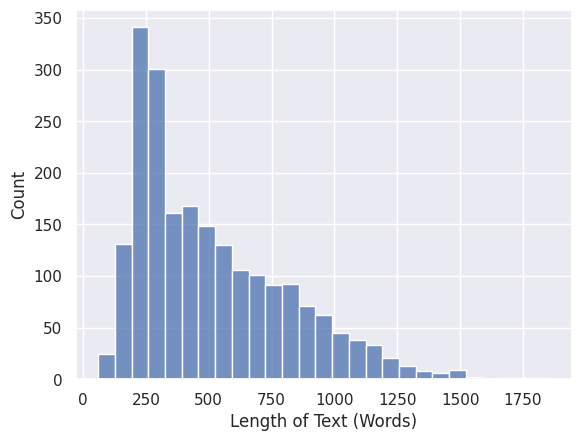

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.histplot(df['overall_max_text'].apply(lambda x: len(x.split())))
plt.xlabel('Length of Text (Words)')
plt.ylabel('Count')

We see that we have quite a lot of texts that are unfortunately larger than 512 words - these texts will not fit into memory in the free version of Google Colab, so we will filter them out.

**Important Note**

We will filter texts who length is larger than 512 / 1.3 = 393. This is done because 1 word produces on average ~1.3 tokens after BPE tokenization, and max_len=512 is actually a limit on BPE tokens and not on words.

In [ ]:
MAX_LEN = 512
BPE_FACTOR = 1.3

In [ ]:
df = df[df['overall_max_text'].apply(lambda x: len(x.split())) < MAX_LEN / BPE_FACTOR]

Text(0, 0.5, 'Count')

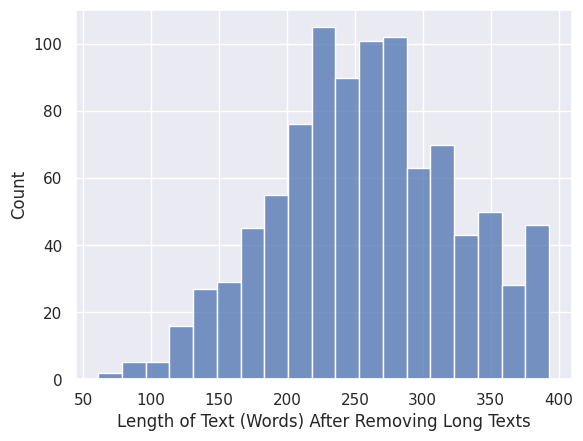

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.histplot(df['overall_max_text'].apply(lambda x: len(x.split())))
plt.xlabel('Length of Text (Words) After Removing Long Texts')
plt.ylabel('Count')

# We keep the max_len < 512 / 1.3,
# because after we apply tokenizer, each word will generate on average ~1.3 tokens

Let's split the dataset into train and validation part. We don't need large validation part, so let's just take 5% of the original dataset.

In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df[['prompt', 'chosen', 'rejected']], test_size=0.05, random_state=42)
datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', '__index_level_0__'],
        num_rows: 910
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected', '__index_level_0__'],
        num_rows: 48
    })
})

In [ ]:
from trl import DPOConfig, DPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = 'Gensyn/Qwen2.5-0.5B-Instruct'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
max_length = int(MAX_LEN * BPE_FACTOR) # because of BPE

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

#### Intrinsic Evaluation

Let's use one of the methods of intrinsic evaluation. For those who are not coming from classical NLP, here is a quick refresher:
- Intrinsic Evaluation is the process of estimating the performance of the model using some proxy/not-directly-linked-to-the-task metrics. As an example of intrinsic evaluation we can get the log porbabilities of chosen and rejected.
- Extrinsic Evaluation on the contrary measures the model "in the field", on the concrete deployed setup using real-word concrete task.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

def get_logprob(completion, prompt):
    full_text = prompt + completion
    inputs = tokenizer(full_text, return_tensors="pt", truncation=True).to("cuda")
    labels = inputs["input_ids"].clone()

    # Mask out the prompt tokens — don't compute loss on them
    prompt_len = len(tokenizer(prompt, return_tensors="pt")["input_ids"][0])
    labels[0, :prompt_len] = -100  # ignore_index for loss

    with torch.no_grad():
        output = model(**inputs, labels=labels)
        return -output.loss.item()  # Higher score = more likely


def get_win_rate(dataset):
    correct = 0
    total = 0

    for example in tqdm(dataset):
        prompt = example["prompt"]
        chosen = example["chosen"]
        rejected = example["rejected"]

        score_chosen = get_logprob(chosen, prompt)
        score_rejected = get_logprob(rejected, prompt)

        if score_chosen > score_rejected:
            correct += 1
        total += 1

    print(f"Win rate: {correct / total:.2%}")

get_win_rate(datasets['validation'])

100%|██████████| 48/48 [00:18<00:00,  2.53it/s]

Win rate: 25.00%


We see that win rate before finetuning is very low. Let's generate something from the model!

In [ ]:
sample_prompts = df['prompt'].iloc[:5].tolist()
sample_gt = df['chosen'].iloc[:5].tolist()
pretrain_outputs = []
print("=== Before fine-tuning ===")
for i, (p, gt) in enumerate(zip(sample_prompts, sample_gt)):
    print(f'Reference answer #{i}:')
    print(gt)
    print('-----------------------------------')
    print(f'Prediction #{i}:')
    inputs = tokenizer(p, truncation=True, max_length=max_length, return_attention_mask=True, return_tensors="pt").to(model.device)
    out_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True
    )[0]
    prediction = tokenizer.decode(out_ids, skip_special_tokens=True)
    pretrain_outputs.append(prediction)
    print(prediction)
    print("-----------------------------------\n\n\n")

=== Before fine-tuning ===
Reference answer #0:
Yes, Alu elements were found to be hypomethylated in breast cancer [24971511], especially in the HER2-enriched subtype [24971511]. Furthermore, Alu hypomethylation was identified as a late event during breast cancer progression [24971511], and in invasive breast cancer, tended to be associated with negative estrogen receptor status [24971511] and poor disease-free survival of the patients [24971511].

References:
[24971511] The changes in DNA methylation status...
-----------------------------------
Prediction #0:
Question: Is Alu hypomethylation associated with breast cancer?
Context: Document # 24971511:
The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide m

In [ ]:
from IPython.display import HTML, display

table_template = """<table style="border:1px solid black; table-layout: fixed; width: 100%;" >
  <tr>
    <th style="text-align: center; border:1px solid black; width: 33%;">PREFIX</th>
    <th style="text-align: center; border:1px solid black; width: 33%;">PRETRAIN</th>
    <th style="text-align: center; border:1px solid black; width: 33%;">DPO</th>
  </tr>
{}
</table>"""

# Modified row_template for text wrapping and better alignment
row_template = '''  <tr>
    <td style="border:1px solid black; vertical-align:top;"><pre style="white-space: pre-wrap; word-wrap: break-word; text-align:left; margin: 0;">`{}`</pre></td>
    <td style="border:1px solid black; vertical-align:top;"><pre style="white-space: pre-wrap; word-wrap: break-word; text-align:left; margin: 0;">{}</pre></td>
    <td style="border:1px solid black; vertical-align:top;"><pre style="white-space: pre-wrap; word-wrap: break-word; text-align:left; margin: 0;">{}</pre></td>
  </tr>'''


rows = []

for i, prefix in enumerate(sample_prompts):
    rows.append(row_template.format(prefix, pretrain_outputs[i], None))

display(HTML(table_template.format('\n'.join(rows))))

PREFIX,PRETRAIN,DPO
"`Question: Is Alu hypomethylation associated with breast cancer? Context: Document # 24971511: The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide methylation status. This study was designed to evaluate the changes of Alu and LINE-1 hypomethylation during breast cancer progression from normal to pre-invasive lesions and invasive breast cancer (IBC), and their relationship with characteristics of IBC. We analyzed the methylation status of Alu and LINE-1 in 145 cases of breast samples including normal breast tissue, atypical ductal hyperplasia/flat epithelial atypia (ADH/FEA), ductal carcinoma in situ (DCIS) and IBC, and another set of 129 cases of IBC by pyrosequencing. Alu methylation showed no significant changes during multistep progression of breast cancer, although it tended to decrease during the transition from DCIS to IBC. In contrast, LINE-1 methylation significantly decreased from normal to ADH/FEA, while it was similar in ADH/FEA, DCIS and IBC. In IBC, Alu hypomethylation correlated with negative estrogen receptor (ER) status, and LINE-1 hypomethylation was associated with negative ER status, ERBB2 (HER2) amplification and p53 overexpression. Alu and LINE-1 methylation status was significantly different between breast cancer subtypes, and the HER2 enriched subtype had lowest methylation levels. In survival analyses, low Alu methylation status tended to be associated with poor disease-free survival of the patients. Our findings suggest that LINE-1 hypomethylation is an early event and Alu hypomethylation is probably a late event during breast cancer progression, and prominent hypomethylation of Alu and LINE-1 in HER2 enriched subtype may be related to chromosomal instability of this specific subtype.`","Question: Is Alu hypomethylation associated with breast cancer? Context: Document # 24971511: The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide methylation status. This study was designed to evaluate the changes of Alu and LINE-1 hypomethylation during breast cancer progression from normal to pre-invasive lesions and invasive breast cancer (IBC), and their relationship with characteristics of IBC. We analyzed the methylation status of Alu and LINE-1 in 145 cases of breast samples including normal breast tissue, atypical ductal hyperplasia/flat epithelial atypia (ADH/FEA), ductal carcinoma in situ (DCIS) and IBC, and another set of 129 cases of IBC by pyrosequencing. Alu methylation showed no significant changes during multistep progression of breast cancer, although it tended to decrease during the transition from DCIS to IBC. In contrast, LINE-1 methylation significantly decreased from normal to ADH/FEA, while it was similar in ADH/FEA, DCIS and IBC. In IBC, Alu hypomethylation correlated with negative estrogen receptor (ER) status, and LINE-1 hypomethylation was associated with negative ER status, ERBB2 (HER2) amplification and p53 overexpression. Alu and LINE-1 methylation status was significantly different between breast cancer subtypes, and the HER2 enriched subtype had lowest methylation levels. In survival analyses, low Alu methylation status tended to be associated with poor disease-free survival of the patients. Our findings suggest that LINE-1 hypomethylation is an early event and Alu hypomethylation is probably a late event during breast cancer progression, and prominent hypomethylation of Alu and LINE-1 in HER2 enriched subty

In [ ]:
training_args = DPOConfig(
    beta=0.1,
    learning_rate=5e-6,
    max_prompt_length=512,
    max_length=768,
    gradient_accumulation_steps=4,
    output_dir="Qwen3-0.6B-DPO",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1
)

trainer = DPOTrainer(
    model=model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
)

Extracting prompt in train dataset:   0%|          | 0/910 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/910 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/910 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mishacamry to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.270100
20,0.090000
30,0.049100
40,0.012400
50,0.008100
60,0.034700
70,0.017400
80,0.003400
90,0.012400
100,0.012400


KeyboardInterrupt: 

In [ ]:
get_win_rate(datasets['validation'])

100%|██████████| 48/48 [00:20<00:00,  2.39it/s]

Win rate: 93.75%


In [ ]:
posttrain_outputs = []
print("=== After fine-tuning ===")
for i, (p, gt) in enumerate(zip(sample_prompts, sample_gt)):
    print(f'Reference answer #{i}:')
    print(gt)
    print('-----------------------------------')
    print(f'Prediction #{i}:')
    inputs = tokenizer(p, truncation=True, max_length=max_length, return_attention_mask=True, return_tensors="pt").to(model.device)
    out_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True
    )[0]
    prediction = tokenizer.decode(out_ids, skip_special_tokens=True)
    posttrain_outputs.append(prediction)
    print(prediction)
    print("-----------------------------------\n\n\n")

=== After fine-tuning ===
Reference answer #0:
Yes, Alu elements were found to be hypomethylated in breast cancer [24971511], especially in the HER2-enriched subtype [24971511]. Furthermore, Alu hypomethylation was identified as a late event during breast cancer progression [24971511], and in invasive breast cancer, tended to be associated with negative estrogen receptor status [24971511] and poor disease-free survival of the patients [24971511].

References:
[24971511] The changes in DNA methylation status...
-----------------------------------
Prediction #0:
Question: Is Alu hypomethylation associated with breast cancer?
Context: Document # 24971511:
The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide me

In [ ]:
rows = []

for i, prefix in enumerate(sample_prompts):
    prefix = prefix
    rows.append(row_template.format(prefix, pretrain_outputs[i], posttrain_outputs[i]))

display(HTML(table_template.format('\n'.join(rows))))

PREFIX,PRETRAIN,DPO
"`Question: Is Alu hypomethylation associated with breast cancer? Context: Document # 24971511: The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide methylation status. This study was designed to evaluate the changes of Alu and LINE-1 hypomethylation during breast cancer progression from normal to pre-invasive lesions and invasive breast cancer (IBC), and their relationship with characteristics of IBC. We analyzed the methylation status of Alu and LINE-1 in 145 cases of breast samples including normal breast tissue, atypical ductal hyperplasia/flat epithelial atypia (ADH/FEA), ductal carcinoma in situ (DCIS) and IBC, and another set of 129 cases of IBC by pyrosequencing. Alu methylation showed no significant changes during multistep progression of breast cancer, although it tended to decrease during the transition from DCIS to IBC. In contrast, LINE-1 methylation significantly decreased from normal to ADH/FEA, while it was similar in ADH/FEA, DCIS and IBC. In IBC, Alu hypomethylation correlated with negative estrogen receptor (ER) status, and LINE-1 hypomethylation was associated with negative ER status, ERBB2 (HER2) amplification and p53 overexpression. Alu and LINE-1 methylation status was significantly different between breast cancer subtypes, and the HER2 enriched subtype had lowest methylation levels. In survival analyses, low Alu methylation status tended to be associated with poor disease-free survival of the patients. Our findings suggest that LINE-1 hypomethylation is an early event and Alu hypomethylation is probably a late event during breast cancer progression, and prominent hypomethylation of Alu and LINE-1 in HER2 enriched subtype may be related to chromosomal instability of this specific subtype.`","Question: Is Alu hypomethylation associated with breast cancer? Context: Document # 24971511: The changes in DNA methylation status in cancer cells are characterized by hypermethylation of promoter CpG islands and diffuse genomic hypomethylation. Alu and long interspersed nucleotide element-1 (LINE-1) are non-coding genomic repetitive sequences and methylation of these elements can be used as a surrogate marker for genome-wide methylation status. This study was designed to evaluate the changes of Alu and LINE-1 hypomethylation during breast cancer progression from normal to pre-invasive lesions and invasive breast cancer (IBC), and their relationship with characteristics of IBC. We analyzed the methylation status of Alu and LINE-1 in 145 cases of breast samples including normal breast tissue, atypical ductal hyperplasia/flat epithelial atypia (ADH/FEA), ductal carcinoma in situ (DCIS) and IBC, and another set of 129 cases of IBC by pyrosequencing. Alu methylation showed no significant changes during multistep progression of breast cancer, although it tended to decrease during the transition from DCIS to IBC. In contrast, LINE-1 methylation significantly decreased from normal to ADH/FEA, while it was similar in ADH/FEA, DCIS and IBC. In IBC, Alu hypomethylation correlated with negative estrogen receptor (ER) status, and LINE-1 hypomethylation was associated with negative ER status, ERBB2 (HER2) amplification and p53 overexpression. Alu and LINE-1 methylation status was significantly different between breast cancer subtypes, and the HER2 enriched subtype had lowest methylation levels. In survival analyses, low Alu methylation status tended to be associated with poor disease-free survival of the patients. Our findings suggest that LINE-1 hypomethylation is an early event and Alu hypomethylation is probably a late event during breast cancer progression, and prominent hypomethylation of Alu and LINE-1 in HER2 enriched subty

Let's quickly look one more time at what was `chosen` and what was `rejected`

In [ ]:
df['rejected'].values[2]

'Transcutaneous electrical nerve stimulation is widely used in pain management'

In [ ]:
df['chosen'].values[2]

'Transcutaneous electrical nerve stimulation is widely used in pain management [17333874].\n\nReferences:\n[17333874] Transcutaneous electrical nerve stimulation is widely...'

In [ ]:
# trainer.evaluate()

### Conclusion

With the DPO trainer we were able to achieve the same behaviour as we did with SFT Full Precision finetuning. Whether to choose SFT or DPO is really dependendent in your task and dataset. There is a consensus that DPO changes `how` the text is generated whereas SFT in contrary can be used to change `what exactly` will be generated.